# Poisson Regression

This notebook implements **Poisson Regression** as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 4)** by Anand Avati.

It includes:
- Feature normalization using **Z-score** 
- Optimization using gradient descent

> 📘 This is part of a broader `ml-from-scratch` project implementing ML algorithms using only NumPy and pandas for educational purposes.



In [1]:
import pickle
import numpy as np
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class PoissonRegression:
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std:ndarray = None
        self.x_norm: ndarray = None
        self.add_bias: bool = True
        self.is_norm: bool = False
        self.theta = None

    @staticmethod
    def g(z: ndarray):
        z_clipped = np.clip(z, a_min=-20, a_max=20)
        return np.exp(z_clipped)

    @staticmethod
    def h(x: ndarray, theta: ndarray):
        return PoissonRegression.g(x @ theta)

    @staticmethod
    def l(theta: ndarray, x: ndarray, y: ndarray):
        lam = PoissonRegression.h(x, theta)
        m = x.shape[0]
        return (1 / m) * np.sum(y * np.log(lam + 1e-10) - lam)

    @staticmethod
    def J(theta, x, y):
        return -PoissonRegression.l(theta, x, y)

    def normalize(self, x_train, add_bias=True):
        print("Data normalizing")
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.x_std[self.x_std == 0] = 1
        self.x_norm = (x_train - self.x_mean) / self.x_std

        if add_bias:
            x_0 = np.ones((x_train.shape[0], 1))
            self.x_norm = np.hstack([x_0, self.x_norm])

        self.add_bias = add_bias
        self.is_norm = True

    def train(self, x_train, y_train, alpha=1e-3, theta=None, max_iter=10000, add_bias=True):
        if not self.is_norm:
            self.normalize(x_train, add_bias)
        m, n = self.x_norm.shape
        if theta is None:
            theta = np.random.randn(n, 1) * 0.001

        losses = []
        i = 0

        while i < max_iter:
            error = self.h(self.x_norm, theta) - y_train
            grad = (1 / m) * (self.x_norm.T @ error)
            grad = np.clip(grad, -10, 10)
            theta -= alpha * grad
            loss = float(PoissonRegression.J(theta, self.x_norm, y_train))
            losses.append(loss)
            i += 1

        self.theta = theta
        print(f"[Converged GD] Final Iter = {i}, Final Loss = {loss:.6f}")
        plt.yscale('symlog')
        plt.plot(range(1, len(losses) + 1), losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Gradient Descent Loss Curve")
        plt.show()

    def save(self, filepath):
        data = {
            "x_mean" : self.x_mean,
            "x_std" : self.x_std,
            "add_bias": self.add_bias,
            "theta" : self.theta
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

    class Loader():
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            self.model = PoissonRegression()
            self.model.x_mean = data.get("x_mean")
            self.model.x_std = data.get("x_std")
            self.model.add_bias = data.get("add_bias")
            self.model.theta = data.get("theta")
            if self.model.theta is None:
                raise ValueError("Invalid Parameter")

        def predict(self, X: ndarray):
            X = np.asarray(X)
            if X.ndim == 1:
                X = X.reshape(1, -1)
            x_mean = np.asarray(self.model.x_mean)
            x_std = np.asarray(self.model.x_std)
            x_norm = (X - x_mean) / x_std
            if self.model.add_bias:
                x_0 = np.ones((x_norm.shape[0], 1))
                x_norm = np.hstack([x_0, x_norm])
            
            return self.model.h(x_norm, self.model.theta)

    

In [3]:
data = pd.read_csv("./data/ds4_train.csv")
data.head()

,x_1,x_2,x_3,x_4,y
0,1.0,0.0,0.992047,0.325741,2463097
1,0.0,1.0,0.470463,0.371866,645481
2,0.0,1.0,0.496533,0.289853,474123
3,0.0,1.0,0.196377,0.694672,1542136
4,0.0,1.0,0.224992,0.880809,3705439


In [4]:
x_train=data[["x_1", "x_2", "x_3", "x_4"]]
y_train=data[["y"]].values

Data normalizing
[Converged GD] Final Iter = 20000, Final Loss = -52198889.444985


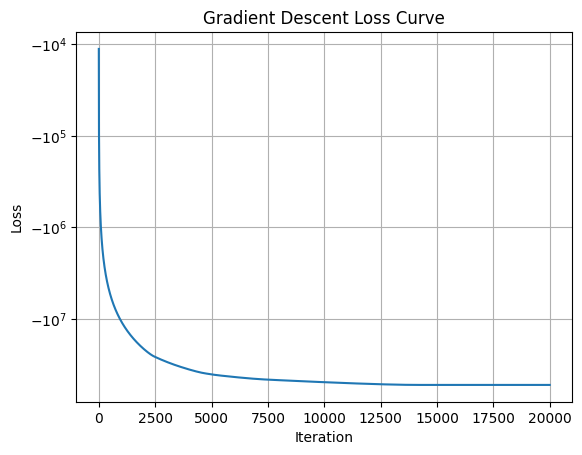

In [5]:
model=PoissonRegression()
model.train(x_train,y_train,alpha=0.0001, max_iter=20000)

In [6]:
y=model.h(model.x_norm, model.theta)


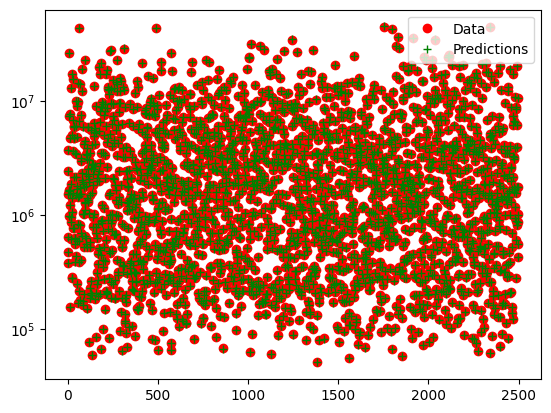

In [7]:
plt.yscale('symlog')
plt.plot(y_train, "ro", label='Data')
plt.plot(y, "g+", label='Predictions')
plt.legend()

In [8]:
model.save("./PoissonRegression.pkl")

In [9]:
val_data = pd.read_csv("./data/ds4_valid.csv")
val_data.head()

,x_1,x_2,x_3,x_4,y
0,0.0,1.0,0.836679,0.869895,12001739
1,0.0,1.0,0.435095,0.724055,2830841
2,1.0,0.0,0.579139,0.995261,20526976
3,0.0,1.0,0.377585,0.621478,1607014
4,0.0,1.0,0.042245,0.498699,479238


In [10]:
x_val=val_data[['x_1','x_2','x_3','x_4']].values
y_val = val_data[['y']].values

In [11]:
infrence=PoissonRegression.Loader('./PoissonRegression.pkl')

In [12]:

ypreds=infrence.predict(x_val)

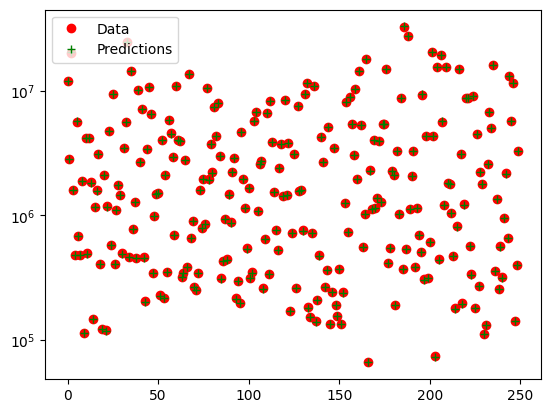

In [13]:
plt.yscale('symlog')
plt.plot(y_val, "ro", label='Data')
plt.plot(ypreds, "g+", label='Predictions')
plt.legend(loc='upper left')